In [77]:
import pandas as pd
from tqdm import tqdm
import json
import os
import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import warnings
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
df_edge = pd.read_csv('Fyp/elliptic_dataset1/elliptic_txs_edgelist.csv')
df_class = pd.read_csv('Fyp/elliptic_dataset1/elliptic_txs_classes.csv')
df_features = pd.read_csv('Fyp/elliptic_dataset1/elliptic_txs_features.csv',header=None)

In [79]:
# renaming columns
df_features.columns = ['txId', 'time step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
df_features.head()

,txId,time step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [80]:
df_index = df_features['txId']
index = df_index.astype(str).tolist()

In [81]:
df_class_features = pd.merge(df_class, df_features)
print(df_class_features)
#display(df_class_features.shape, df_class_features.head())

             txId    class  time step  trans_feat_0  trans_feat_1  \
0       230425980  unknown          1     -0.171469     -0.184668   
1         5530458  unknown          1     -0.171484     -0.184668   
2       232022460  unknown          1     -0.172107     -0.184668   
3       232438397        2          1      0.163054      1.963790   
4       230460314  unknown          1      1.011523     -0.081127   
...           ...      ...        ...           ...           ...   
203764  173077460  unknown         49     -0.145771     -0.163752   
203765  158577750  unknown         49     -0.165920     -0.123607   
203766  158375402        1         49     -0.172014     -0.078182   
203767  158654197  unknown         49     -0.172842     -0.176622   
203768  157597225  unknown         49     -0.012037     -0.132276   

        trans_feat_2  trans_feat_3  trans_feat_4  trans_feat_5  trans_feat_6  \
0          -1.201369     -0.121970     -0.043875     -0.113002     -0.061584   
1          

In [82]:
df_class_features_NoIndex = df_class_features.copy()
df_features_NoIndex = df_class_features_NoIndex.drop(columns=['txId'])
df_features_NoIndex.index = index
display(df_features_NoIndex.shape, df_features_NoIndex.head())

(203769, 167)

,class,time step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [83]:
df_unlabelled_class_features = df_features_NoIndex[df_features_NoIndex['class'] == 'unknown']
df_labelled_class_features = df_unlabelled_class_features.drop(columns=['class'])
#display(df_labelled_class_features.shape, df_labelled_class_features.head())

df_labelled_class_features = df_features_NoIndex[df_features_NoIndex['class'] != 'unknown']
df_labelled_class_features = df_labelled_class_features.drop(columns=['class'])
display(df_labelled_class_features.shape, df_labelled_class_features.head())

(46564, 166)

,time step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [84]:
labelled_node_list = df_labelled_class_features.index.tolist()

In [85]:
df_edge.columns = ['source', 'target']
display(df_edge.shape,df_edge)

(234355, 2)

,source,target
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


In [86]:
"""
df_labelled_node_edge = df_edge.copy()
df_unlabelled_node_edge = df_edge.copy()
with open('Edge_Matching_Processed.txt') as f:
    lines = f.readlines()

TotalCount = 1
count = 0
for line in lines:
    count = count + 1
    line = line.replace("\n","")
    if count == 1:
        index = int(line)
        print(index)

    if line == 'not match':
        df_labelled_node_edge = df_labelled_node_edge.drop(index)
        print("labelled_list_drop")
    elif line == 'dropped':
        df_unlabelled_node_edge = df_unlabelled_node_edge.drop(index)
        print("unlabelled_list_drop")
    elif line == '==============':
        TotalCount = TotalCount + 1
        count = 0
"""


'\ndf_labelled_node_edge = df_edge.copy()\ndf_unlabelled_node_edge = df_edge.copy()\nwith open(\'Edge_Matching_Processed.txt\') as f:\n    lines = f.readlines()\n\nTotalCount = 1\ncount = 0\nfor line in lines:\n    count = count + 1\n    line = line.replace("\n","")\n    if count == 1:\n        index = int(line)\n        print(index)\n\n    if line == \'not match\':\n        df_labelled_node_edge = df_labelled_node_edge.drop(index)\n        print("labelled_list_drop")\n    elif line == \'dropped\':\n        df_unlabelled_node_edge = df_unlabelled_node_edge.drop(index)\n        print("unlabelled_list_drop")\n    elif line == \'==============\':\n        TotalCount = TotalCount + 1\n        count = 0\n'

In [87]:
df_labelled_node_edge = pd.read_csv('labelled_node_edge.txt', sep=" ")
df_unlabelled_node_edge = pd.read_csv('unlabelled_node_edge.txt', sep=" ")
print(df_labelled_node_edge)
print(df_unlabelled_node_edge)

          source     target
0      232344069   27553029
1        3881097  232457116
2      232051089  232470704
3      230473487    7089694
4      231182296   14660781
...          ...        ...
36619  194020062   47521535
36620  158574502  109383451
36621  158594124  157631640
36622  157631640   21644119
36623  158365409  157930723

[36624 rows x 2 columns]
           source     target
0       230425980    5530458
1       232022460  232438397
2       230460314  230459870
3       230333930  230595899
4       232013274  232029206
...           ...        ...
197726  157579987  157579982
197727  188708874  188708879
197728  157659064  157659046
197729   87414554  106877725
197730  158589452  158589457

[197731 rows x 2 columns]


In [88]:
#print(df_labelled_node_edge.shape, df_labelled_node_edge.head())
#np.savetxt(r'.\labelled_node_edge.txt', df_labelled_node_edge.values, fmt='%d')

In [89]:
#print(df_unlabelled_node_edge.shape, df_unlabelled_node_edge.head())
#np.savetxt(r'.\unlabelled_node_edge.txt', df_unlabelled_node_edge.values, fmt='%d')

In [90]:
"""
print(df_edge.shape)
source_labelled = False
target_labelled = False
df_labelled_node_edge = df_edge.copy()
df_unlabelled_node_edge = df_edge.copy()

for index, row in df_edge.iterrows():
    #reset the counter
    print("==============")
    print(index)
    source_labelled = False
    target_labelled = False 
    for node in labelled_node_list:
        if df_edge['source'][index] == node:
            print("sucess1")
            source_labelled = True
        
        if df_edge['target'][index] == node:
            print("sucess2")
            target_labelled = True

        if source_labelled == True and target_labelled == True:
            print("dropped")
            df_unlabelled_node_edge = df_unlabelled_node_edge.drop(index)
            break
        
    if source_labelled == False or target_labelled == False:
        print("not match")
        df_labelled_node_edge = df_labelled_node_edge.drop(index)
"""


'\nprint(df_edge.shape)\nsource_labelled = False\ntarget_labelled = False\ndf_labelled_node_edge = df_edge.copy()\ndf_unlabelled_node_edge = df_edge.copy()\n\nfor index, row in df_edge.iterrows():\n    #reset the counter\n    print("==============")\n    print(index)\n    source_labelled = False\n    target_labelled = False \n    for node in labelled_node_list:\n        if df_edge[\'source\'][index] == node:\n            print("sucess1")\n            source_labelled = True\n        \n        if df_edge[\'target\'][index] == node:\n            print("sucess2")\n            target_labelled = True\n\n        if source_labelled == True and target_labelled == True:\n            print("dropped")\n            df_unlabelled_node_edge = df_unlabelled_node_edge.drop(index)\n            break\n        \n    if source_labelled == False or target_labelled == False:\n        print("not match")\n        df_labelled_node_edge = df_labelled_node_edge.drop(index)\n'

In [91]:
#Original class1(illicit), class2(licit)
df_class.index = df_class.index.map(str)
df_class.index.name = "id"
df_class["class"].value_counts(normalize=True)
#class "2" change to class "0"
#class 1: illicit
#class 0: licit

unknown    0.771486
2          0.206209
1          0.022305
Name: class, dtype: float64

In [92]:
#display(df_class.shape, df_class.head())
df_class_index = df_class['txId']
class_index = df_class_index.astype(str).tolist()

In [93]:
df_modify_class = df_class.copy()
df_modify_class.index = class_index
print(df_modify_class.head())

                txId    class
230425980  230425980  unknown
5530458      5530458  unknown
232022460  232022460  unknown
232438397  232438397        2
230460314  230460314  unknown


In [94]:

Unlabelled_classes = df_modify_class[df_modify_class['class'] == 'unknown']
print("Unlabelled_classes Info:")
display(Unlabelled_classes.shape, Unlabelled_classes.head())
#display(Unlabelled_classes.shape, Unlabelled_classes.head())
labelled_classes = df_modify_class[df_modify_class['class'] != 'unknown']
print("Labelled_classes Info:")
display(labelled_classes.shape, labelled_classes.head())

Unlabelled_classes Info:


(157205, 2)

,txId,class
230425980,230425980,unknown
5530458,5530458,unknown
232022460,232022460,unknown
230460314,230460314,unknown
230459870,230459870,unknown


Labelled_classes Info:


(46564, 2)

,txId,class
232438397,232438397,2
232029206,232029206,2
232344069,232344069,2
27553029,27553029,2
3881097,3881097,2


In [95]:
# Function to evaluate
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    print('ROC AUC:', auc)
    print('PR AUC:', pr)
    print('F1 score:', f_score)
    print(confusion_matrix(true, bin_pred, normalize='true'))
    
    return auc, pr, f_score

StellarGraph Data

In [96]:
G = sg.StellarGraph(df_labelled_class_features, df_labelled_node_edge.astype(str))

In [97]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 46564, Edges: 36624

 Node types:
  default: [46564]
    Features: float32 vector, length 166
    Edge types: default-default->default

 Edge types:
    default-default->default: [36624]
        Weights: all 1 (default)
        Features: none


Train/Test/Val Split

In [98]:
target_encoding = LabelBinarizer()

train_pages, test_pages = train_test_split(labelled_classes, train_size=0.25)
val_pages, test_pages = train_test_split(test_pages, train_size=0.25)


In [99]:
all_targets = target_encoding.fit_transform(labelled_classes['class'])
train_targets = target_encoding.fit_transform(train_pages['class'])
val_targets = target_encoding.fit_transform(val_pages['class'])
test_targets = target_encoding.fit_transform(test_pages['class'])

Model Trainning

In [100]:
# Initialise the generator
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [101]:
# Use the .flow method to prepare it for use with GCN
train_gen = generator.flow(train_pages.index, train_targets)
val_gen = generator.flow(val_pages.index, val_targets)
test_gen = generator.flow(test_pages.index, test_targets)

In [102]:
# Build necessary layers
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

# Access the input and output tensors
x_inp, x_out = gcn.in_out_tensors()

# Pass the output tensor through the dense layer with sigmoid
predictions = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

In [103]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

C:\ProgramData\Anaconda3\envs\downgrade\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [104]:
# Early stopping callback
es_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [105]:
# Train the model
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.1526 - acc: 0.4263 - val_loss: 0.3419 - val_acc: 0.8562 - 837ms/epoch - 837ms/step
Epoch 2/200
1/1 - 0s - loss: 0.5117 - acc: 0.7861 - val_loss: 0.3541 - val_acc: 0.8970 - 171ms/epoch - 171ms/step
Epoch 3/200
1/1 - 0s - loss: 0.4108 - acc: 0.8803 - val_loss: 0.3837 - val_acc: 0.8998 - 171ms/epoch - 171ms/step
Epoch 4/200
1/1 - 0s - loss: 0.4286 - acc: 0.9018 - val_loss: 0.3895 - val_acc: 0.9003 - 166ms/epoch - 166ms/step
Epoch 5/200
1/1 - 0s - loss: 0.4527 - acc: 0.9058 - val_loss: 0.3735 - val_acc: 0.9005 - 162ms/epoch - 162ms/step
Epoch 6/200
1/1 - 0s - loss: 0.4436 - acc: 0.9046 - val_loss: 0.3442 - val_acc: 0.9003 - 161ms/epoch - 161ms/step
Epoch 7/200
1/1 - 0s - loss: 0.4095 - acc: 0.9048 - val_loss: 0.3098 - val_acc: 0.9005 - 162ms/epoch - 162ms/step
Epoch 8/200
1/1 - 0s - loss: 0.3788 - acc: 0.9052 - val_loss: 0.2770 - val_acc: 0.9006 - 174ms/epoch - 174ms/step
Epoch 9/200
1/1 - 0s - loss: 0.3451 - acc: 0.9052 - val_loss: 0.2490 - val_acc: 0.9005 -

In [106]:
new_preds = model.predict(test_gen)
print(new_preds[0].ravel())

[0.99906456 1.         0.91563445 ... 0.93266726 0.99022436 0.9998898 ]


In [107]:
auc, pr, f_score = evaluate_preds(test_targets.ravel(),new_preds[0].ravel())

ROC AUC: 0.9627356796798601
PR AUC: 0.9949450437145304
F1 score: 0.9790303080835453
[[0.66497462 0.33502538]
 [0.00626269 0.99373731]]


Graph Generation

In [108]:
"""
# Define the embedding model
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)

# Get indices of all nodes
all_indices = get_node_indices(G, targets.index)

#Get embeddings
emb = embedding_model.predict([features_input, all_indices, A_input])
print(emb.shape)
# Shape: (1, 37700, 32)
"""

# UMAP for visualisation
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(labelled_classes[['class']])
print(umap_embs)

[[13.908399   3.1838071]
 [12.378907   5.9183197]
 [ 8.651473   3.9301443]
 ...
 [-5.5300493  6.372758 ]
 [ 9.83115    3.9643764]
 [-5.261993   6.003567 ]]


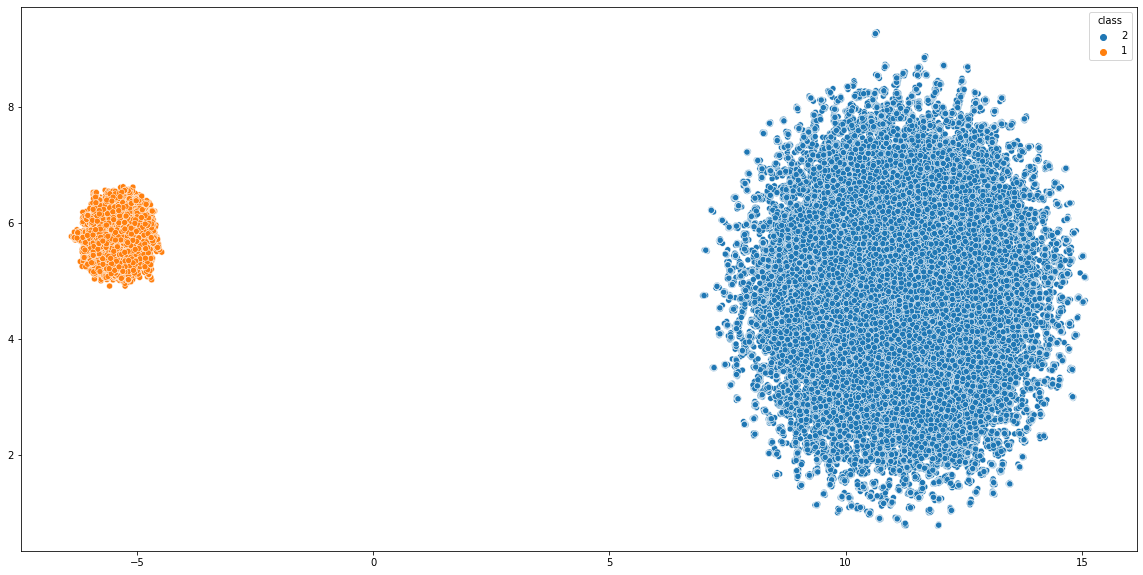

In [109]:
#Plot the embeddingsembe
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = labelled_classes['class'])

Prepare Data for other models

In [110]:
labelled_target_class =  labelled_classes['class'].tolist()
df_labelled_class_features['class'] = labelled_target_class

In [111]:
all_gen = generator.flow(labelled_classes.index, all_targets)
all_new_preds = model.predict(all_gen)
print(all_new_preds.size)

46564


In [112]:
GCN_Pred_Values = all_new_preds[0].ravel().tolist()

In [113]:
df_labelled_features_GCN = df_labelled_class_features.copy()
df_labelled_features_GCN['gcn_values'] = GCN_Pred_Values

Split Train/Test Data

In [114]:
X_train = df_labelled_class_features[df_labelled_class_features['time step'] <= 30]
X_test = df_labelled_class_features[df_labelled_class_features['time step'] > 30]
y_train = X_train['class']
y_test = X_test['class']

X_train = X_train.drop(columns=['class', 'time step'])
X_test = X_test.drop(columns=['class', 'time step'])

In [115]:
#dropped class, text id and time step already
#Only use the local features
X_train_localfeatures = X_train.iloc[:, 0:94]
X_test_localfeatures = X_test.iloc[:, 0:94]

In [116]:
X_train_gcn = df_labelled_features_GCN[df_labelled_features_GCN['time step'] <= 30]
X_test_gcn = df_labelled_features_GCN[df_labelled_features_GCN['time step'] > 30]
y_train_gcn = X_train_gcn['class']
y_test_gcn = X_test_gcn['class']

X_train_gcn = X_train_gcn.drop(columns=['class', 'time step'])
X_test_gcn = X_test_gcn.drop(columns=['class', 'time step'])

In [117]:
#dropped class, text id and time step already
#Only use the local features
X_train_localfeatures_gcn = X_train_gcn.iloc[:, 0:94]
X_test_localfeatures_gcn = X_test_gcn.iloc[:, 0:94]

Train RandomForest Model - Overall Result

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm

RF - Without GCN Value

In [119]:
model_RF_AF = RandomForestClassifier(n_estimators = 100, bootstrap = False, min_samples_leaf=1, max_depth=50)
model_RF_AF.fit(X_train.values,y_train.values)
y_preds = model_RF_AF.predict(X_test.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds)

print("Random Forest Classifier (AF)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

Random Forest Classifier (AF)
Precision:0.982 
Recall:0.994 
F1 Score:0.988


In [120]:
model_RF_LF = RandomForestClassifier(n_estimators = 100, bootstrap = False, min_samples_leaf=1, max_depth=50)
model_RF_LF.fit(X_train_localfeatures.values,y_train.values)
y_preds = model_RF_LF.predict(X_test_localfeatures.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds)

print("Random Forest Classifier (LF)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

Random Forest Classifier (LF)
Precision:0.981 
Recall:0.993 
F1 Score:0.987


SVM - Without GCN Value

In [121]:
#class 0: licit
#class 1: illicit
y_train_new = [-1 if i=="1" else 1 for i in y_train]
print(y_train_new.count(1))

23951


In [122]:
model_SVM_AF = svm.OneClassSVM(gamma = 0.01, kernel = 'poly', nu = 0.01)
model_SVM_AF.fit(X_train.values,y_train_new)

y_preds = model_SVM_AF.predict(X_test.values)

y_preds_new = ['1' if i==-1 else '2' for i in y_preds]

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_new)

print("One-class SVM (AF)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

One-class SVM (AF)
Precision:0.892 
Recall:0.577 
F1 Score:0.701


In [123]:
model_SVM_LF = svm.OneClassSVM(gamma = 0.01, kernel = 'poly', nu = 0.01)
model_SVM_LF.fit(X_train_localfeatures.values,y_train_new)

y_preds = model_SVM_LF.predict(X_test_localfeatures.values)

y_preds_new = ['1' if i==-1 else '2' for i in y_preds]
y_preds_new = np.array(y_preds_new)

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds_new)

print("One-class SVM (LF)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

One-class SVM (LF)
Precision:0.922 
Recall:0.950 
F1 Score:0.935


RF - With GCN Value

In [124]:
model_RF_GCN_AF = RandomForestClassifier(n_estimators = 100, bootstrap = False, min_samples_leaf=1, max_depth=50)
model_RF_GCN_AF.fit(X_train_gcn.values,y_train_gcn.values)
y_preds = model_RF_GCN_AF.predict(X_test_gcn.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test_gcn.values, y_preds)

print("Random Forest Classifier + GCN (AF)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

Random Forest Classifier + GCN (AF)
Precision:0.982 
Recall:0.997 
F1 Score:0.990


In [125]:
model_RF_GCN_LF = RandomForestClassifier(n_estimators = 100, bootstrap = False, min_samples_leaf=1, max_depth=50)
model_RF_GCN_LF.fit(X_train_localfeatures_gcn.values,y_train_gcn.values)
y_preds = model_RF_GCN_LF.predict(X_test_localfeatures_gcn.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test_gcn.values, y_preds)

print("Random Forest Classifier + GCN (LF)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

Random Forest Classifier + GCN (LF)
Precision:0.981 
Recall:0.993 
F1 Score:0.987


SVM - With GCN Value

In [126]:
y_train_new = [-1 if i==1 else 1 for i in y_train_gcn]

model_SVM_GCN_AF = svm.OneClassSVM(gamma = 0.01, kernel = 'poly', nu = 0.01)
model_SVM_GCN_AF.fit(X_train_gcn.values,y_train_gcn)

y_preds = model_SVM_GCN_AF.predict(X_test_gcn.values)

y_preds_new = ['1' if i==-1 else '2' for i in y_preds]

prec,rec,f1,num = precision_recall_fscore_support(y_test_gcn.values, y_preds_new)

print("One-class SVM + GCN (AF)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

One-class SVM + GCN (AF)
Precision:0.904 
Recall:0.692 
F1 Score:0.784


In [127]:
y_train_new = [-1 if i==1 else 1 for i in y_train_gcn]

model_SVM_GCN_LF = svm.OneClassSVM(gamma = 0.01, kernel = 'poly', nu = 0.01)
model_SVM_GCN_LF.fit(X_train_localfeatures_gcn.values,y_train_gcn)

y_preds = model_SVM_GCN_LF.predict(X_test_localfeatures_gcn.values)

y_preds_new = ['1' if i==-1 else '2' for i in y_preds]

prec,rec,f1,num = precision_recall_fscore_support(y_test_gcn.values, y_preds_new)

print("One-class SVM + GCN (LF)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

One-class SVM + GCN (LF)
Precision:0.922 
Recall:0.950 
F1 Score:0.935


Predict By TimeStep

In [128]:
def TrainDataByTime(TrainingModel, OriginalData, modelName, Requirement = "AF"):
    prec_list = []
    rec_list = []
    f1_list = []
    for time in range(31, 50):
        test_X = OriginalData[OriginalData['time step'] == time]
        test_y = test_X['class']
        test_X = test_X.drop(columns=['class', 'time step'])
        if Requirement == "LF":
            test_X = test_X.iloc[:, 0:94]

        y_preds = TrainingModel.predict(test_X.values)

        if modelName == "SVM":
            y_preds = ['1' if i==-1 else '2' for i in y_preds]
        
        prec,rec,f1,num = precision_recall_fscore_support(test_y.values, y_preds)
        
        prec_list.append(prec[1])
        rec_list.append(rec[1])
        f1_list.append(f1[1])

    return prec_list, rec_list, f1_list

In [129]:
RF_AF_prec, RF_AF_rec, RF_AF_f1 = TrainDataByTime(model_RF_AF, df_labelled_class_features, 'RF')
RF_LF_prec, RF_LF_rec, RF_LF_f1 = TrainDataByTime(model_RF_LF, df_labelled_class_features, 'RF', 'LF')
SVM_AF_prec, SVM_AF_rec, SVM_AF_f1 = TrainDataByTime(model_SVM_AF, df_labelled_class_features, 'SVM')
SVM_LF_prec, SVM_LF_rec, SVM_LF_f1 = TrainDataByTime(model_SVM_LF, df_labelled_class_features, 'SVM', 'LF')

In [130]:
RF_GCN_AF_prec, RF_GCN_AF_rec, RF_GCN_AF_f1 = TrainDataByTime(model_RF_GCN_AF, df_labelled_features_GCN, 'RF')
RF_GCN_LF_prec, RF_GCN_LF_rec, RF_GCN_LF_f1 = TrainDataByTime(model_RF_GCN_LF, df_labelled_features_GCN, 'RF', 'LF')
SVM_GCN_AF_prec, SVM_GCN_AF_rec, SVM_GCN_AF_f1 = TrainDataByTime(model_SVM_GCN_AF, df_labelled_features_GCN, 'SVM')
SVM_GCN_LF_prec, SVM_GCN_LF_rec, SVM_GCN_LF_f1 = TrainDataByTime(model_SVM_GCN_LF, df_labelled_features_GCN, 'SVM', 'LF')

C:\ProgramData\Anaconda3\envs\downgrade\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
Timestep = []
for time in range(31, 50):
    Timestep.append(time)
    
Timestep = np.array(Timestep)

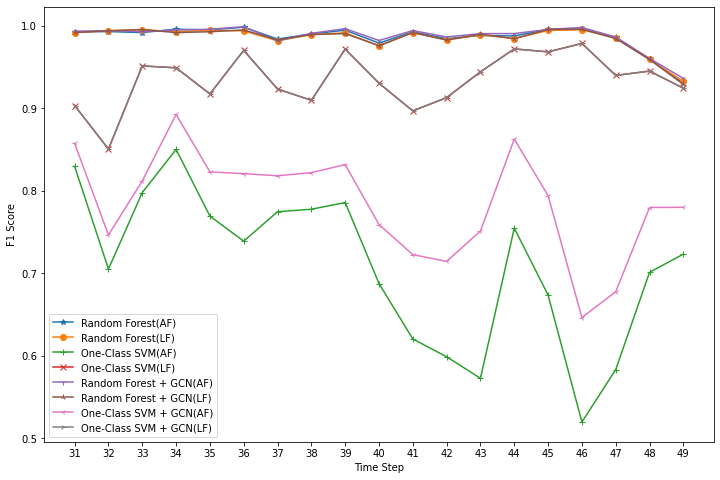

In [132]:
plt.figure(figsize=(12,8))
plt.plot(Timestep, RF_AF_f1, marker = '*', label = "Random Forest(AF)")
plt.plot(Timestep, RF_LF_f1, marker = 'o', label = "Random Forest(LF)")
plt.plot(Timestep, SVM_AF_f1, marker = '+', label = "One-Class SVM(AF)")
plt.plot(Timestep, SVM_LF_f1, marker = 'x', label = "One-Class SVM(LF)")
plt.plot(Timestep, RF_GCN_AF_f1,marker = '1', label = "Random Forest + GCN(AF)")
plt.plot(Timestep, RF_GCN_LF_f1,marker = '2', label = "Random Forest + GCN(LF)")
plt.plot(Timestep, SVM_GCN_AF_f1,marker = '3', label = "One-Class SVM + GCN(AF)")
plt.plot(Timestep, SVM_GCN_LF_f1,marker = '4', label = "One-Class SVM + GCN(LF)")
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('F1 Score')
plt.xticks(Timestep)
plt.show()